# **Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import pandas as pd

# **AISK Class**

In [2]:
class AISK:
    """
    Artificial Immune System K-means clustering algorithm

    Parameters:
    -----------
    n_clusters : int
        Number of clusters to find (K)
    memory_size : int
        Size of memory cell (M)
    remainder_size : int
        Size of remainder cell (P_r)
    selection_size : int
        Number of top antibodies to select for cloning (n)
    clone_factor : int
        Factor for cloning (f)
    rho : float
        Parameter for mutation rate calculation
    max_iter : int
        Maximum number of iterations
    random_state : int or None
        Random seed for reproducibility
    """

    def __init__(self, n_clusters=3, memory_size=10, remainder_size=20, selection_size=5,
                 clone_factor=3, rho=1.0, max_iter=50, random_state=None):
        self.n_clusters = n_clusters
        self.memory_size = memory_size
        self.remainder_size = remainder_size
        self.selection_size = selection_size
        self.clone_factor = clone_factor
        self.rho = rho
        self.max_iter = max_iter
        self.random_state = random_state
        self.population_size = memory_size + remainder_size
        self.rng = np.random.RandomState(random_state)

        # Results will be stored here
        self.best_antibody = None
        self.labels_ = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.affinities_history = []

    def _initialize_antibodies(self, X):
        """Initialize population of antibodies with random centroids"""
        n_features = X.shape[1]

        # Initialize antibody population
        antibodies = []

        # Calculate min/max for each feature to constrain random initialization
        min_vals = X.min(axis=0)
        max_vals = X.max(axis=0)

        # Generate antibodies
        for _ in range(self.population_size):
            # Each antibody is K cluster centroids
            centroids = np.zeros((self.n_clusters, n_features))
            for k in range(self.n_clusters):
                # Generate random centroids within the data bounds
                centroids[k] = min_vals + self.rng.random(n_features) * (max_vals - min_vals)
            antibodies.append(centroids)

        return np.array(antibodies)

    def _calculate_affinity(self, X, antibody):
        """Calculate affinity (fitness) for a single antibody using Equation 3"""
        # Assign each point to nearest centroid
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            # Calculate Euclidean distance from each point to centroid k
            diff = X - antibody[k]
            distances[:, k] = np.sqrt(np.sum(diff**2, axis=1))

        # Assign each point to closest centroid
        labels = np.argmin(distances, axis=1)

        # Calculate SED (Sum of Euclidean Distances) - Equation 4
        sed = 0
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if cluster_points.shape[0] > 0:  # Skip empty clusters
                sed += np.sum(np.linalg.norm(cluster_points - antibody[k], axis=1))

        # Calculate affinity (Equation 3)
        affinity = 1 / (1 + sed)

        return affinity, labels, sed

    def _calculate_all_affinities(self, X, antibodies):
        """Calculate affinities for all antibodies"""
        affinities = np.zeros(len(antibodies))
        all_labels = []
        all_seds = []

        for i, antibody in enumerate(antibodies):
            affinity, labels, sed = self._calculate_affinity(X, antibody)
            affinities[i] = affinity
            all_labels.append(labels)
            all_seds.append(sed)

        return affinities, all_labels, all_seds

    def _clonal_selection(self, antibodies, affinities):
        """Select top n antibodies and clone them proportionally to affinity"""
        # Find indices of top n antibodies
        top_indices = np.argsort(affinities)[-self.selection_size:]

        # Get top n antibodies and their affinities
        top_antibodies = antibodies[top_indices]
        top_affinities = affinities[top_indices]

        # Calculate number of clones per antibody (Equation 7)
        total_clones = self.selection_size * self.clone_factor
        clone_counts = np.round(total_clones * (top_affinities / np.sum(top_affinities))).astype(int)

        # Make sure we have exactly total_clones by adjusting last count
        clone_counts[-1] = total_clones - np.sum(clone_counts[:-1])

        # Create clones
        clones = []
        clone_parents = []  # Keep track of which antibody produced each clone

        for i, (antibody, count) in enumerate(zip(top_antibodies, clone_counts)):
            for _ in range(count):
                clones.append(antibody.copy())
                clone_parents.append(top_indices[i])

        return np.array(clones), np.array(clone_parents), top_indices

    def _affinity_maturation(self, X, clones, affinities, clone_parents):
        """Mutate clones according to their parent's affinity (Equations 8-9)"""
        # Normalize affinities (Equation 8)
        parent_affinities = affinities[clone_parents]
        max_affinity = np.max(affinities)
        normalized_affinities = parent_affinities / max_affinity

        # Calculate mutation rates (Equation 8)
        mutation_rates = np.exp(-self.rho * normalized_affinities)

        # Apply Gaussian mutation (Equation 9)
        mutated_clones = clones.copy()

        for i, (clone, mutation_rate) in enumerate(zip(clones, mutation_rates)):
            # Generate random number r ~ U(0,1)
            r = self.rng.random()

            # Apply mutation if r < mutation_rate
            if r < mutation_rate:
                # Apply Gaussian mutation to each centroid element
                noise = mutation_rate * self.rng.normal(0, 1, clone.shape)
                mutated_clones[i] = clone + noise

        return mutated_clones

    def _update_centroids(self, X, antibodies, all_labels):
        """Update centroids for each antibody (Equation 11)"""
        updated_antibodies = antibodies.copy()

        for i, (antibody, labels) in enumerate(zip(antibodies, all_labels)):
            for k in range(self.n_clusters):
                cluster_points = X[labels == k]
                if cluster_points.shape[0] > 0:  # Skip empty clusters
                    updated_antibodies[i][k] = np.mean(cluster_points, axis=0)

        return updated_antibodies

    def fit(self, X):
        """Fit the AISK clustering model to the data"""
        X = np.asarray(X)

        # Initialize antibody population
        antibodies = self._initialize_antibodies(X)

        # Main loop (Step 12)
        for iteration in range(self.max_iter):
            # Calculate affinities (Step 3)
            affinities, all_labels, all_seds = self._calculate_all_affinities(X, antibodies)
            self.affinities_history.append(np.max(affinities))

            # Select and clone antibodies (Steps 4-5)
            clones, clone_parents, top_indices = self._clonal_selection(antibodies, affinities)

            # Apply affinity maturation (Step 6)
            mutated_clones = self._affinity_maturation(X, clones, affinities, clone_parents)

            # Calculate affinities for mutated clones
            clone_affinities, clone_labels, clone_seds = self._calculate_all_affinities(X, mutated_clones)

            # Update centroids using K-means approach (Steps 7-9)
            updated_clones = self._update_centroids(X, mutated_clones, clone_labels)

            # Recalculate affinities after centroid update
            updated_affinities, updated_labels, updated_seds = self._calculate_all_affinities(X, updated_clones)

            # Update memory (Step 10) - select best M antibodies
            all_candidates = np.vstack([antibodies, updated_clones])
            all_candidate_affinities = np.concatenate([affinities, updated_affinities])
            all_candidate_labels = all_labels + updated_labels
            all_candidate_seds = all_seds + updated_seds

            # Select the best memory_size antibodies
            best_indices = np.argsort(all_candidate_affinities)[-self.memory_size:]
            memory_antibodies = all_candidates[best_indices]
            memory_affinities = all_candidate_affinities[best_indices]
            memory_labels = [all_candidate_labels[i] for i in best_indices]
            memory_seds = [all_candidate_seds[i] for i in best_indices]

            # Generate new remainder antibodies (Step 11)
            new_remainder = self._initialize_antibodies(X)[:self.remainder_size]

            # Combine memory and remainder for new population
            antibodies = np.vstack([memory_antibodies, new_remainder])

            # Print iteration progress
            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration + 1}, Best affinity: {np.max(memory_affinities):.6f}")

        # Get best antibody after all iterations
        best_idx = np.argmax(memory_affinities)
        self.best_antibody = memory_antibodies[best_idx]
        self.labels_ = memory_labels[best_idx]
        self.cluster_centers_ = self.best_antibody
        self.inertia_ = memory_seds[best_idx]

        return self

    def predict(self, X):
        """Predict cluster labels for new data points"""
        X = np.asarray(X)

        # Calculate distances to each centroid
        distances = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            diff = X - self.cluster_centers_[k]
            distances[:, k] = np.sqrt(np.sum(diff**2, axis=1))

        # Assign points to closest centroid
        labels = np.argmin(distances, axis=1)

        return labels

# **Apply the result on synthetic data**

In [ ]:
def test_aisk_on_blobs():
    # Generate synthetic data
    X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42)

    # Create and fit AISK model
    aisk = AISK(n_clusters=4, memory_size=10, remainder_size=20,
                selection_size=5, clone_factor=3, rho=1.0,
                max_iter=30, random_state=42)
    aisk.fit(X)

    # Get cluster assignments
    y_pred = aisk.labels_

    # Calculate silhouette score
    silhouette = silhouette_score(X, y_pred)
    print(f"Silhouette Score: {silhouette:.4f}")

    # Visualize results
    plt.figure(figsize=(12, 5))

    # Original data plot
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', s=50, alpha=0.8)
    plt.title('Original Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    # Clustered data plot
    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', s=50, alpha=0.8)

    # Plot centroids
    centroids = aisk.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    plt.title(f'AISK Clustering (Silhouette: {silhouette:.4f})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

    plt.tight_layout()
    plt.savefig('aisk_blobs_results.png')
    plt.show()

    # Plot convergence
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(aisk.affinities_history) + 1), aisk.affinities_history, marker='o')
    plt.title('AISK Convergence')
    plt.xlabel('Iteration')
    plt.ylabel('Best Affinity')
    plt.grid(True)
    plt.savefig('aisk_convergence.png')
    plt.show()

    return aisk, X, y_true, y_pred

Iteration 10, Best affinity: 0.004541
Iteration 20, Best affinity: 0.004541
Iteration 30, Best affinity: 0.004541
Silhouette Score: 0.8756


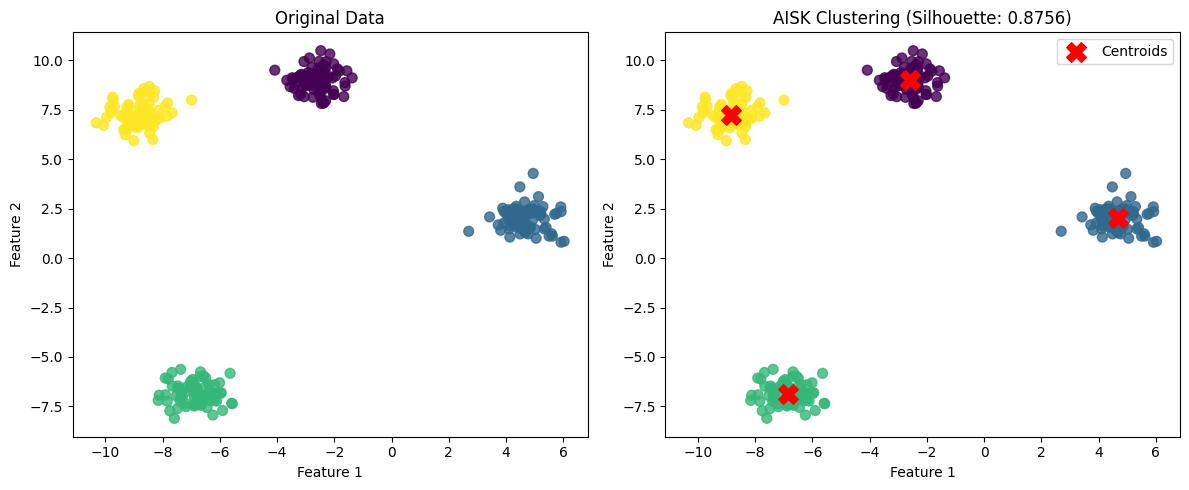

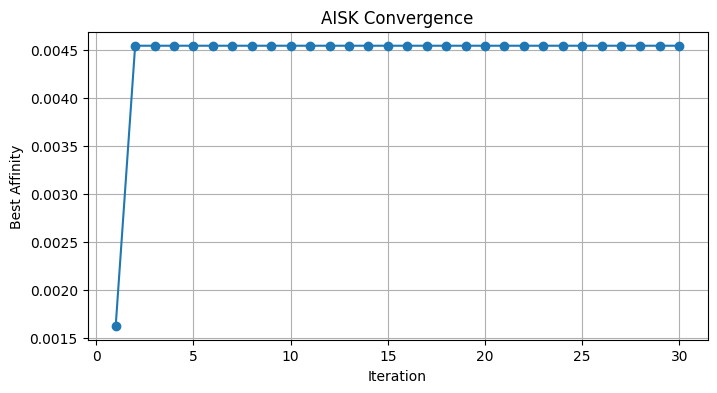

In [ ]:
aisk_model, X_blobs, y_true, y_pred = test_aisk_on_blobs()

# **Apply the result on real data**

In [ ]:
data_1= pd.read_csv('/content/processed_data.csv')
data_1.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


In [ ]:
def visualize_customer_segments(X, labels, centroids, feature_names):
    """
    Visualize customer segments in 3D using the first three features

    Parameters:
    - X: data
    - labels: cluster assignments
    - centroids: cluster centers
    - feature_names: names of the features
    """
    # Plot the 3D scatter plot (first 3 features)
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cluster with a different color
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    markers = ['o', 's', '^', 'D', '*', 'p', 'h', 'v', '>', '<']

    for i in range(len(np.unique(labels))):
        ax.scatter(
            X[labels == i, 0],
            X[labels == i, 1],
            X[labels == i, 2],
            c=colors[i % len(colors)],
            marker=markers[i % len(markers)],
            label=f'Cluster {i+1}',
            alpha=0.7,
            s=80
        )

    # Plot centroids
    ax.scatter(
        centroids[:, 0],
        centroids[:, 1],
        centroids[:, 2],
        c='black',
        marker='X',
        s=200,
        label='Centroids'
    )

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.set_title('AISK Customer Segmentation', fontsize=15)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot convergence curve
    plt.figure(figsize=(10, 6))
    plt.plot(aisk.affinities_history)
    plt.title('AISK Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Affinity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Additional 2D plots for all possible pairs of features
    n_features = X.shape[1]
    if n_features >= 2:
        fig, axes = plt.subplots(1, n_features-1, figsize=(15, 5))

        if n_features == 2:  # Handle the case with only 2 features
            axes = [axes]

        for i in range(n_features-1):
            # Scatter plot for each pair of consecutive features
            for j in range(len(np.unique(labels))):
                axes[i].scatter(
                    X[labels == j, i],
                    X[labels == j, i+1],
                    c=colors[j % len(colors)],
                    marker=markers[j % len(markers)],
                    label=f'Cluster {j+1}',
                    alpha=0.7
                )

            # Plot centroids
            axes[i].scatter(
                centroids[:, i],
                centroids[:, i+1],
                c='black',
                marker='X',
                s=200
            )

            axes[i].set_xlabel(feature_names[i])
            axes[i].set_ylabel(feature_names[i+1])
            axes[i].grid(True)

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(np.unique(labels))+1)
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.15)
        plt.show()

In [ ]:
X = data_1.values

# Choose number of clusters
n_clusters = 3

# Apply KCGWO
aisk = AISK(n_clusters=n_clusters, memory_size=10, remainder_size=20,
                selection_size=5, clone_factor=3, rho=1.0,
                max_iter=30, random_state=42)
aisk.fit(X)

# Get cluster labels
labels = aisk.predict(X)

# Get cluster centroids
centroids = aisk.cluster_centers_

print(f"AISK best score (inertia): {aisk.inertia_:.4f}")
print("Cluster sizes:", [np.sum(labels == i) for i in range(n_clusters)])
print("Centroids:\n", centroids)

Iteration 10, Best affinity: 0.004080
Iteration 20, Best affinity: 0.004080
Iteration 30, Best affinity: 0.004080
AISK best score (inertia): 244.0697
Cluster sizes: [np.int64(64), np.int64(40), np.int64(96)]
Centroids:
 [[-0.96747018 -0.62503908  0.2191925   0.41538462]
 [-0.44191719  0.99158305  1.23950275  0.46153846]
 [ 0.8345868   0.02037293 -0.65195959  0.44791667]]


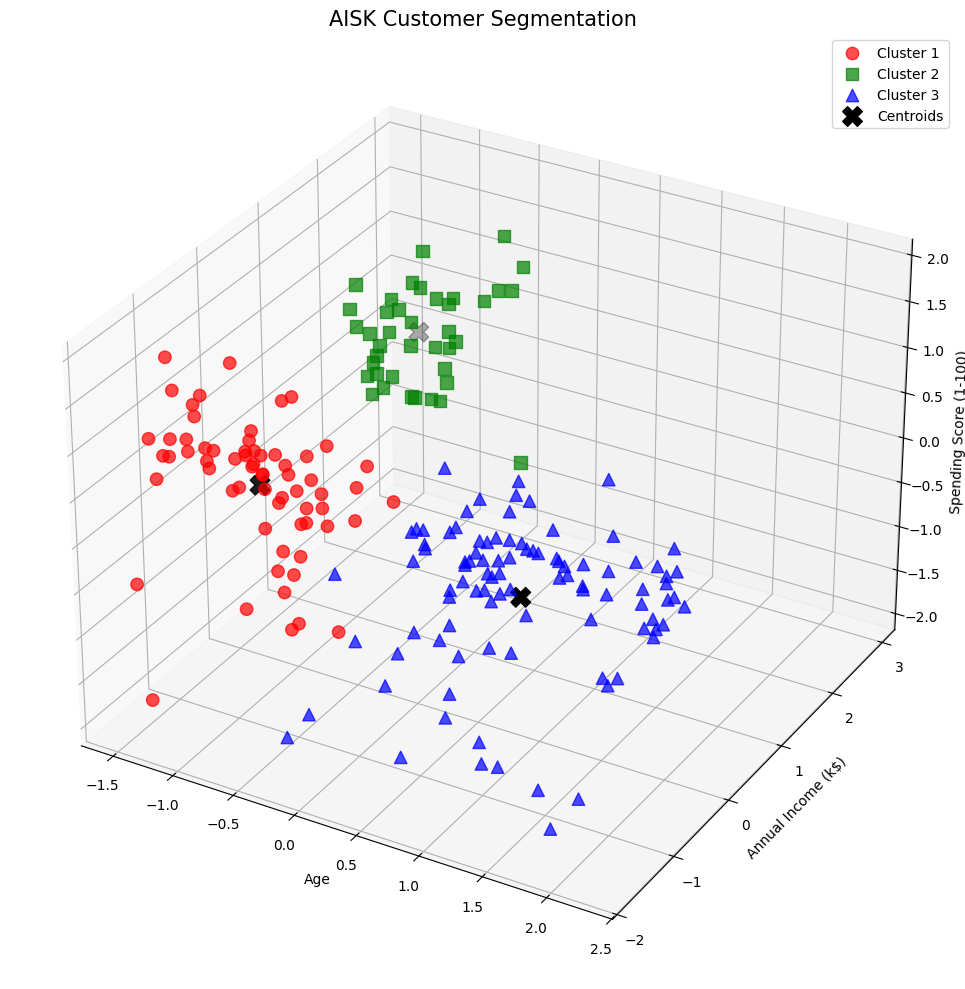

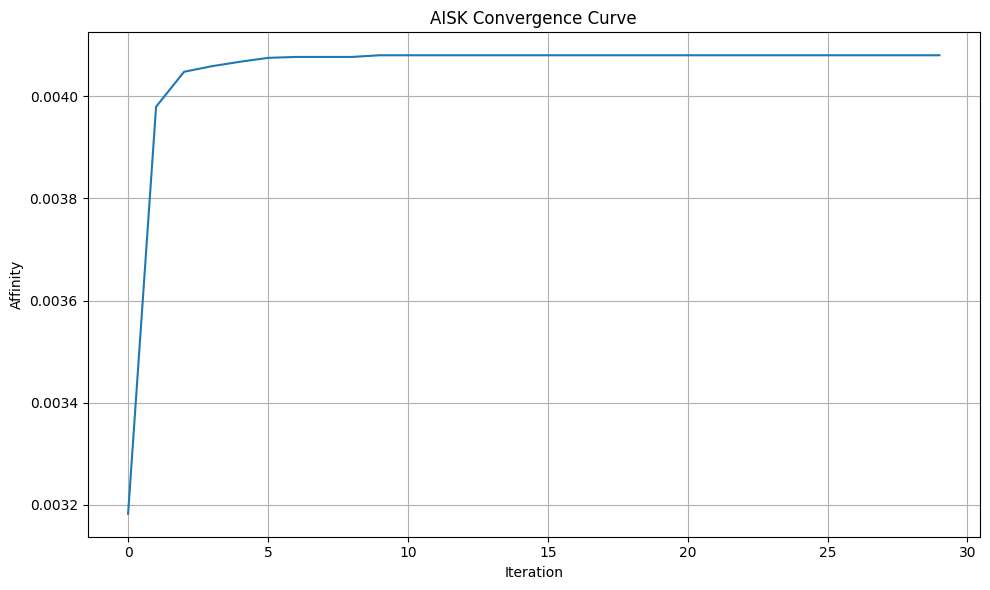

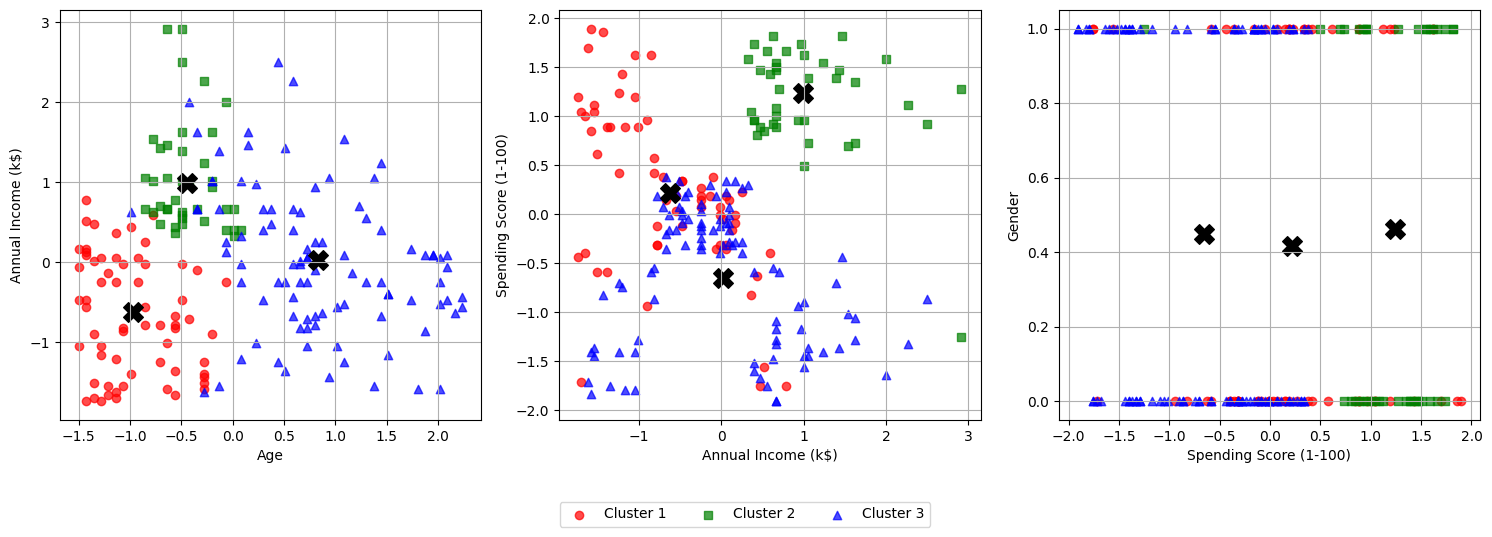

In [ ]:
visualize_customer_segments(X,labels,centroids,data_1.columns)

# **Evaluation metrics**

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate silhouette score (values closer to 1 indicate better clustering)
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Calculate Davies-Bouldin Index (lower values indicate better clustering)
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")

# Calculate Calinski-Harabasz Index (higher values indicate better clustering)
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Silhouette Score: 0.3145
Davies-Bouldin Index: 1.1550
Calinski-Harabasz Index: 87.0247


# **Comparison with kmeans**


Comparison with standard K-means:
K-means inertia: 344.6849
AISK inertia: 244.0697
Improvement: 29.19%
K-means Silhouette Score: 0.3150
KCGWO Silhouette Score: 0.3145


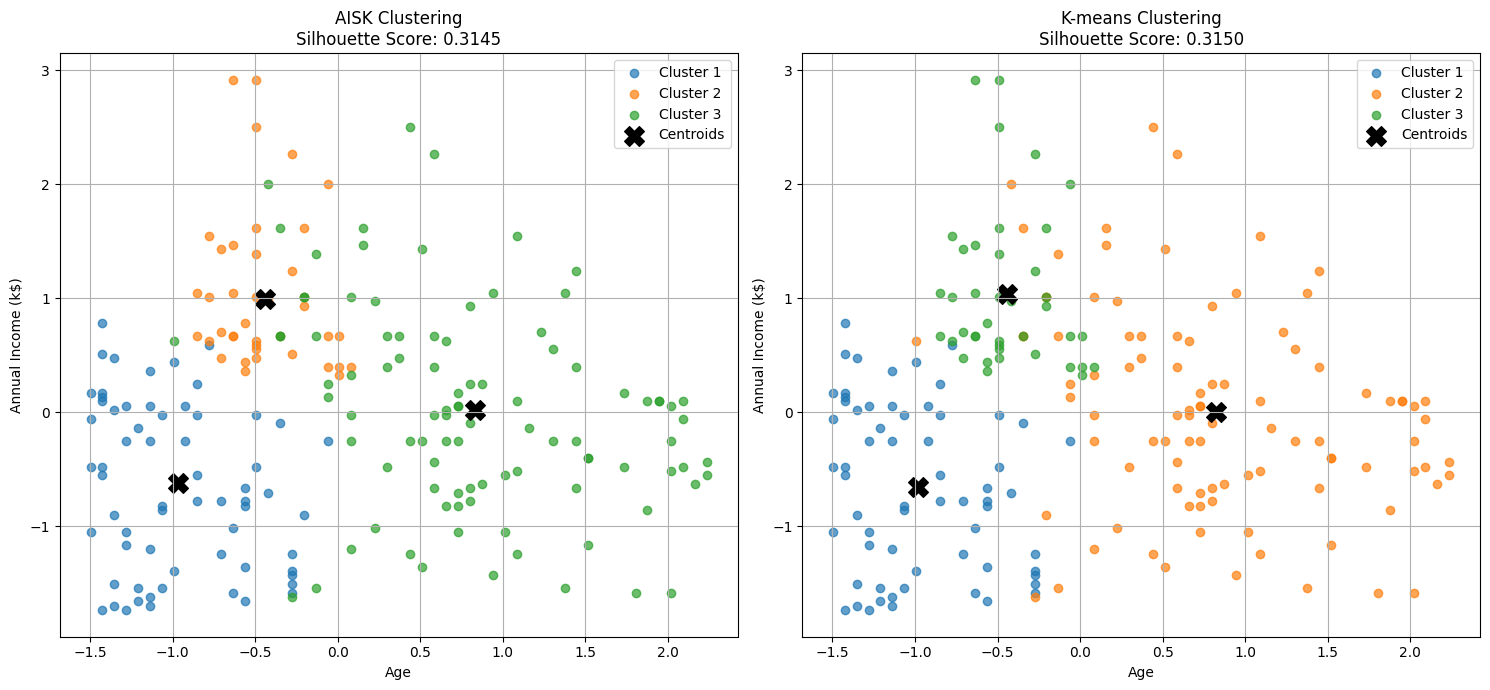

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
kmeans_score = kmeans.inertia_

print("\nComparison with standard K-means:")
print(f"K-means inertia: {kmeans_score:.4f}")
print(f"AISK inertia: {aisk.inertia_:.4f}")
print(f"Improvement: {((kmeans_score - aisk.inertia_) / kmeans_score) * 100:.2f}%")

# Silhouette score for K-means
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f"K-means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"KCGWO Silhouette Score: {silhouette_avg:.4f}")

# Plot comparison of cluster results
plt.figure(figsize=(15, 7))

# Plot KCGWO clustering
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i+1}', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title(f'AISK Clustering\nSilhouette Score: {silhouette_avg:.4f}')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.legend()
plt.grid(True)

# Plot K-means clustering
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    plt.scatter(X[kmeans_labels == i, 0], X[kmeans_labels == i, 1], label=f'Cluster {i+1}', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title(f'K-means Clustering\nSilhouette Score: {kmeans_silhouette:.4f}')
plt.xlabel('Age')
plt.ylabel('Annual Income (k$)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [3]:
data_train= pd.read_csv("/content/train_processed_data.csv")
data_train

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,-1.284623,-0.499892,0.757947,1,0,0,5,2,3,3
1,-0.327151,0.537954,0.096095,0,1,1,2,0,3,0
2,1.408268,-0.499892,-1.227610,0,1,1,2,2,5,1
3,1.408268,-0.805141,-0.565758,1,1,1,7,1,5,1
4,-0.207467,1.453700,2.081652,0,1,1,3,1,5,0
...,...,...,...,...,...,...,...,...,...,...
8063,-1.284623,-0.805141,2.743505,1,0,0,0,2,0,3
8064,-0.506677,0.110605,0.757947,1,0,0,4,2,3,3
8065,-0.626361,-0.499892,-1.227610,0,0,1,5,2,5,3
8066,-0.985413,-0.499892,0.757947,0,0,1,5,2,5,1


In [ ]:
data_test = pd.read_csv("/content/test_processed_data.csv")
data_test

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
0,-0.450948,-0.792867,-1.196222,0,1,1,2,2,5
1,-0.391999,1.696957,0.767498,1,1,1,5,0,5
2,1.494372,-0.792867,-1.196222,0,1,0,0,2,5
3,0.904881,2.630641,-0.541649,1,1,0,4,1,5
4,-1.453083,-0.045920,0.767498,0,0,0,8,2,5
...,...,...,...,...,...,...,...,...,...
2622,-0.863592,2.008185,0.767498,1,0,0,5,2,5
2623,-0.509897,-0.481639,-1.196222,0,0,1,1,2,5
2624,0.551187,0.514290,-0.541649,0,0,1,3,2,5
2625,0.197492,-0.481639,1.422071,1,1,1,4,1,3


In [ ]:
X = data_train.values

# Choose number of clusters
n_clusters = 3

# Apply AISK
aisk =AISK(n_clusters=n_clusters, memory_size=10, remainder_size=20,
              selection_size=5, clone_factor=3, rho=1.0,
              max_iter=50, random_state=42)
aisk.fit(X)

# Get cluster labels
labels = aisk.predict(X)

# Get cluster centroids
centroids = aisk.cluster_centers_

print(f"AISK best score (inertia): {aisk.inertia_:.4f}")
print("Cluster sizes:", [np.sum(labels == i) for i in range(n_clusters)])
print("Centroids:\n", centroids)

Iteration 10, Best affinity: 0.000045
Iteration 20, Best affinity: 0.000045
Iteration 30, Best affinity: 0.000045
Iteration 40, Best affinity: 0.000045
Iteration 50, Best affinity: 0.000045
AISK best score (inertia): 22040.7457
Cluster sizes: [np.int64(1571), np.int64(3182), np.int64(3315)]
Centroids:
 [[-0.09911235 -0.06373938  0.14504007  0.51270648  0.65438374  0.60038119
   1.37420584  1.19949174  2.15057179  1.20965693]
 [-0.04958058  0.01539154  0.17331106  0.59762774  0.49543796  0.4823601
   5.39172749  1.60249392  4.24270073  2.01034063]
 [ 0.09950836  0.01550792 -0.24895192  0.51310044  0.6625078   0.78446663
   0.70835933  1.18995633  5.02994386  1.27510917]]


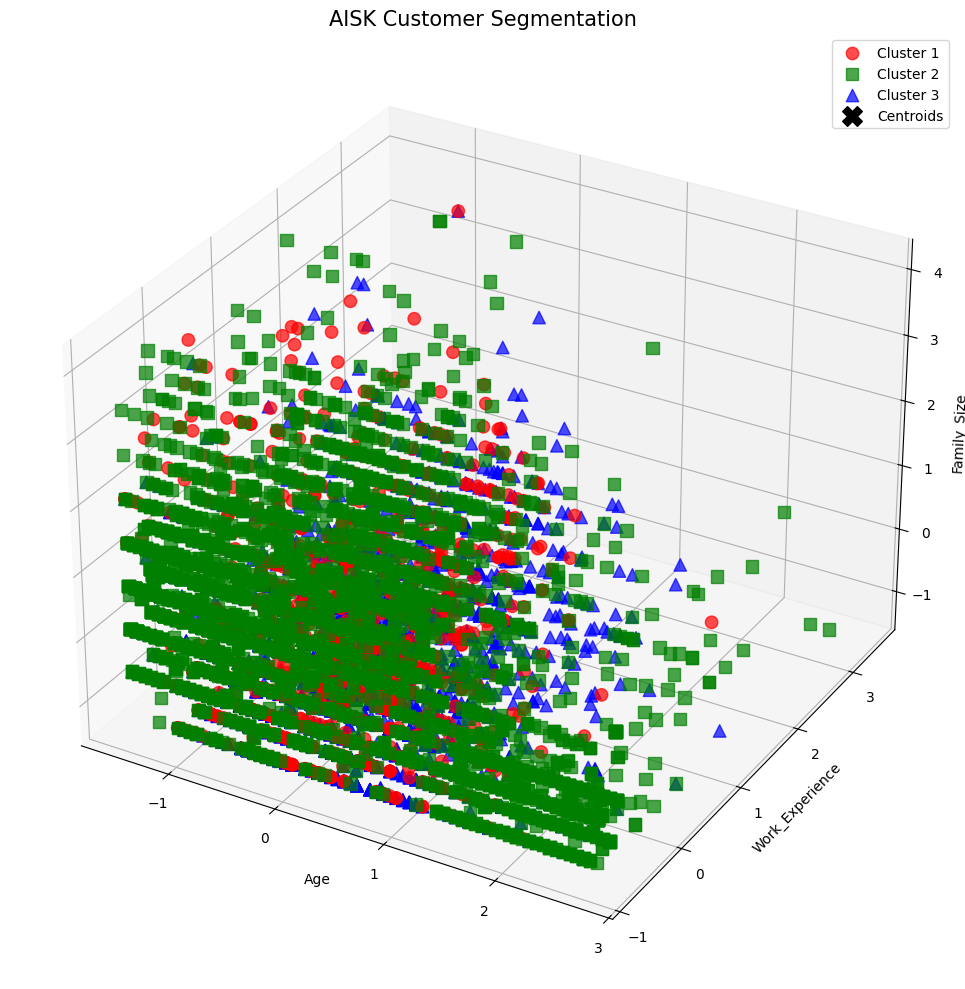

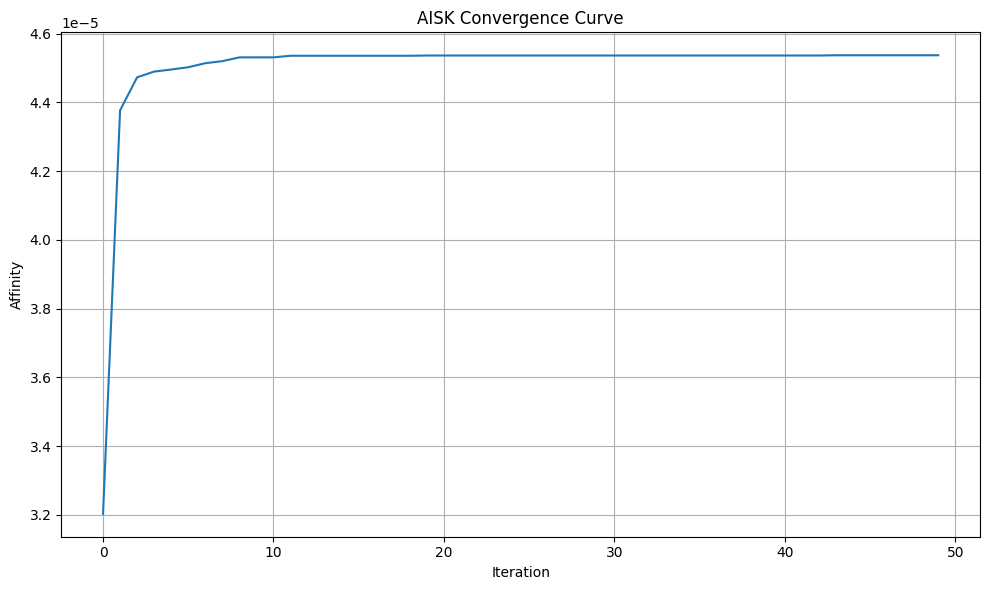

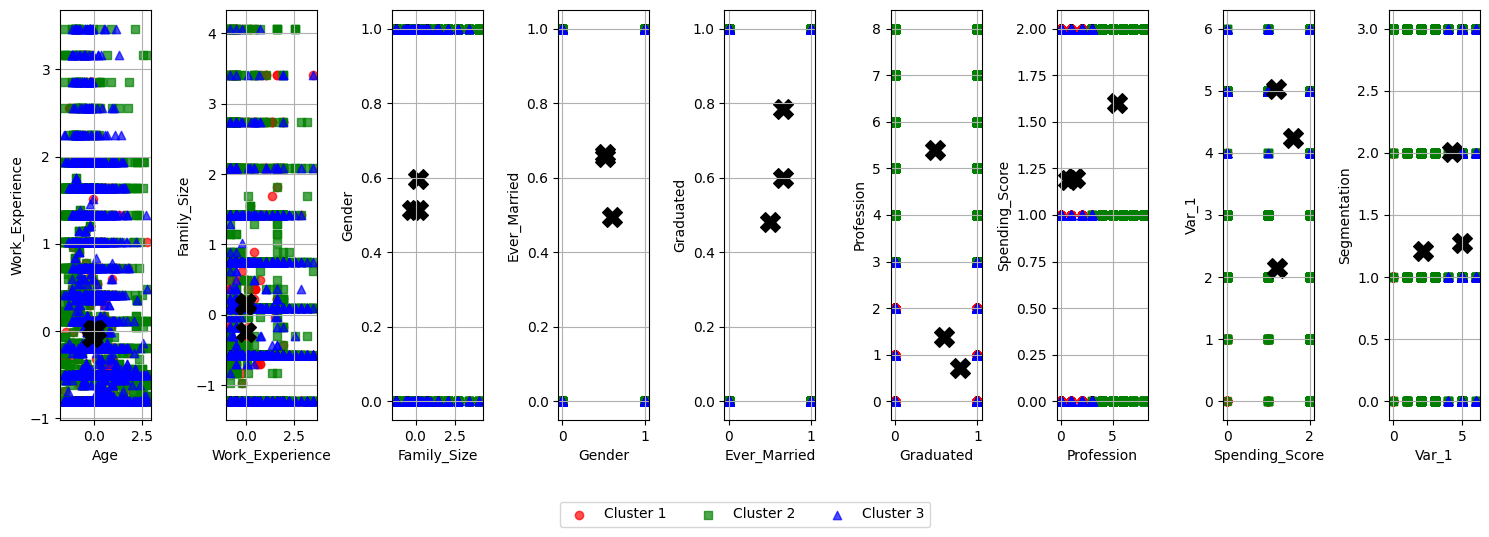

In [ ]:
visualize_customer_segments(X,labels,centroids,data_train.columns)

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Calculate silhouette score (values closer to 1 indicate better clustering)
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Calculate Davies-Bouldin Index (lower values indicate better clustering)
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")

# Calculate Calinski-Harabasz Index (higher values indicate better clustering)
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Silhouette Score: 0.2447
Davies-Bouldin Index: 1.5715
Calinski-Harabasz Index: 3165.8364



Comparison with standard K-means:
K-means inertia: 64199.0430
AISK inertia: 22040.7457
Improvement: 65.67%
K-means Silhouette Score: 0.2443
AISK Silhouette Score: 0.2447


<ipython-input-32-a470f27ec162>:41: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


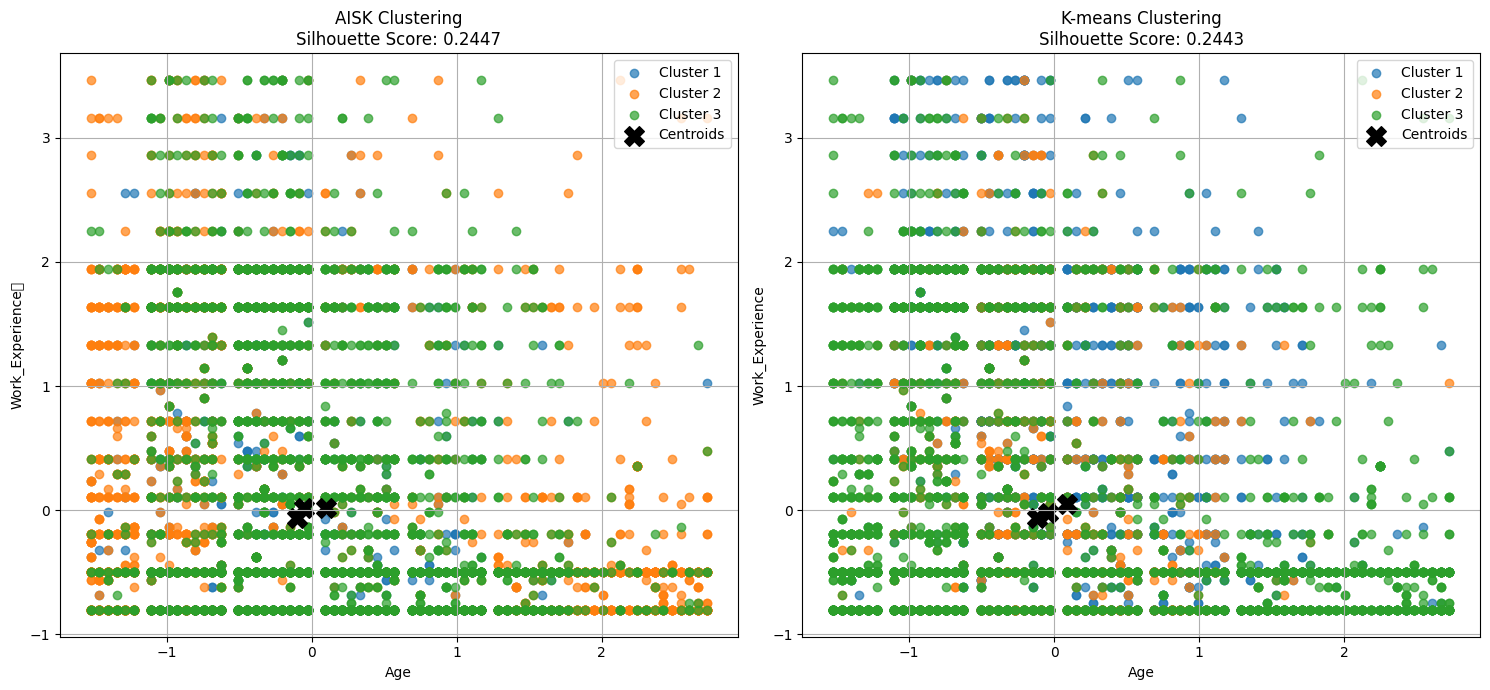

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
kmeans_score = kmeans.inertia_

print("\nComparison with standard K-means:")
print(f"K-means inertia: {kmeans_score:.4f}")
print(f"AISK inertia: {aisk.inertia_:.4f}")
print(f"Improvement: {((kmeans_score - aisk.inertia_) / kmeans_score) * 100:.2f}%")

# Silhouette score for K-means
kmeans_silhouette = silhouette_score(X, kmeans_labels)
print(f"K-means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"AISK Silhouette Score: {silhouette_avg:.4f}")

# Plot comparison of cluster results
plt.figure(figsize=(15, 7))

# Plot AISK clustering
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], label=f'Cluster {i+1}', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title(f'AISK Clustering\nSilhouette Score: {silhouette_avg:.4f}')
plt.xlabel('Age')
plt.ylabel('Work_Experience	')
plt.legend()
plt.grid(True)

# Plot K-means clustering
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    plt.scatter(X[kmeans_labels == i, 0], X[kmeans_labels == i, 1], label=f'Cluster {i+1}', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Centroids')
plt.title(f'K-means Clustering\nSilhouette Score: {kmeans_silhouette:.4f}')
plt.xlabel('Age')
plt.ylabel('Work_Experience')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Real test**

In [4]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [5]:
import pandas as pd

In [7]:
X= data_train.values
results={
    "k":[],
    "inertia":[],
    "silhouette":[],
    "ch_score":[],
    "db_score":[]
}

ks= list(range(3,11))

for k in ks:
  print(f"run for k = {k}")
  for run in range(30):
    print(f"run {run}")
    aisk =AISK(n_clusters=k, memory_size=10, remainder_size=20,
              selection_size=5, clone_factor=3, rho=1.0,
              max_iter=50, random_state=42)
    aisk.fit(X)
    labels= aisk.predict(X)
    inertia = aisk.inertia_
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X,labels)
    db_score = davies_bouldin_score(X, labels)

    results['k'].append(k)
    results['inertia'].append(inertia)
    results['silhouette'].append(silhouette)
    results['ch_score'].append(ch_score)
    results['db_score'].append(db_score)


run for k = 3
run 0
Iteration 10, Best affinity: 0.000045
Iteration 20, Best affinity: 0.000045
Iteration 30, Best affinity: 0.000045
Iteration 40, Best affinity: 0.000045
Iteration 50, Best affinity: 0.000045
run 1
Iteration 10, Best affinity: 0.000045
Iteration 20, Best affinity: 0.000045
Iteration 30, Best affinity: 0.000045
Iteration 40, Best affinity: 0.000045
Iteration 50, Best affinity: 0.000045
run 2
Iteration 10, Best affinity: 0.000045
Iteration 20, Best affinity: 0.000045
Iteration 30, Best affinity: 0.000045
Iteration 40, Best affinity: 0.000045
Iteration 50, Best affinity: 0.000045
run 3
Iteration 10, Best affinity: 0.000045
Iteration 20, Best affinity: 0.000045
Iteration 30, Best affinity: 0.000045
Iteration 40, Best affinity: 0.000045
Iteration 50, Best affinity: 0.000045
run 4
Iteration 10, Best affinity: 0.000045
Iteration 20, Best affinity: 0.000045
Iteration 30, Best affinity: 0.000045
Iteration 40, Best affinity: 0.000045
Iteration 50, Best affinity: 0.000045
run 5


In [9]:
runs_df= pd.DataFrame(results)

In [10]:
runs_df

,k,inertia,silhouette,ch_score,db_score
0,3,22040.745691,0.244725,3165.836357,1.571482
1,3,22040.745691,0.244725,3165.836357,1.571482
2,3,22040.745691,0.244725,3165.836357,1.571482
3,3,22040.745691,0.244725,3165.836357,1.571482
4,3,22040.745691,0.244725,3165.836357,1.571482
...,...,...,...,...,...
235,10,16702.226581,0.208428,1772.619112,1.545615
236,10,16702.226581,0.208428,1772.619112,1.545615
237,10,16702.226581,0.208428,1772.619112,1.545615
238,10,16702.226581,0.208428,1772.619112,1.545615


In [11]:
runs_df.to_csv("/content/AISK_runs.csv",index=True)

In [12]:
avarage_df_runs= runs_df.groupby("k").mean()

In [13]:
avarage_df_runs

,inertia,silhouette,ch_score,db_score
k,,,,
3,22040.745691,0.244725,3165.836357,1.571482
4,20610.429145,0.231656,2751.213815,1.618799
5,19457.252850,0.228734,2539.161042,1.509894
6,18834.811419,0.190799,2232.259762,1.624534
7,17873.941983,0.199801,2161.748659,1.530933
8,17486.786673,0.203141,1995.720069,1.663181
9,17122.784286,0.199352,1851.546230,1.653112
10,16702.226581,0.208428,1772.619112,1.545615


In [15]:
avarage_df_runs.to_csv("/content/AISK_avarage_runs.csv",index=True)

In [21]:
data_test= pd.read_csv("/content/test_processed_data.csv")
data_test.drop(['Var_1'],axis=1)

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score
0,-0.450948,-0.792867,-1.196222,0,1,1,2,2
1,-0.391999,1.696957,0.767498,1,1,1,5,0
2,1.494372,-0.792867,-1.196222,0,1,0,0,2
3,0.904881,2.630641,-0.541649,1,1,0,4,1
4,-1.453083,-0.045920,0.767498,0,0,0,8,2
...,...,...,...,...,...,...,...,...
2622,-0.863592,2.008185,0.767498,1,0,0,5,2
2623,-0.509897,-0.481639,-1.196222,0,0,1,1,2
2624,0.551187,0.514290,-0.541649,0,0,1,3,2
2625,0.197492,-0.481639,1.422071,1,1,1,4,1


In [22]:
X= data_test.drop(['Var_1'],axis=1).values
results={
    "k":[],
    "inertia":[],
    "silhouette":[],
    "ch_score":[],
    "db_score":[]
}

ks= list(range(3,11))

for k in ks:
  print(f"run for k = {k}")
  for run in range(30):
    print(f"run {run}")
    aisk =AISK(n_clusters=k, memory_size=10, remainder_size=20,
              selection_size=5, clone_factor=3, rho=1.0,
              max_iter=50, random_state=42)
    aisk.fit(X)
    labels= aisk.predict(X)
    inertia = aisk.inertia_
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X,labels)
    db_score = davies_bouldin_score(X, labels)

    results['k'].append(k)
    results['inertia'].append(inertia)
    results['silhouette'].append(silhouette)
    results['ch_score'].append(ch_score)
    results['db_score'].append(db_score)


run for k = 3
run 0
Iteration 10, Best affinity: 0.000182
Iteration 20, Best affinity: 0.000182
Iteration 30, Best affinity: 0.000182
Iteration 40, Best affinity: 0.000182
Iteration 50, Best affinity: 0.000182
run 1
Iteration 10, Best affinity: 0.000182
Iteration 20, Best affinity: 0.000182
Iteration 30, Best affinity: 0.000182
Iteration 40, Best affinity: 0.000182
Iteration 50, Best affinity: 0.000182
run 2
Iteration 10, Best affinity: 0.000182
Iteration 20, Best affinity: 0.000182
Iteration 30, Best affinity: 0.000182
Iteration 40, Best affinity: 0.000182
Iteration 50, Best affinity: 0.000182
run 3
Iteration 10, Best affinity: 0.000182
Iteration 20, Best affinity: 0.000182
Iteration 30, Best affinity: 0.000182
Iteration 40, Best affinity: 0.000182
Iteration 50, Best affinity: 0.000182
run 4
Iteration 10, Best affinity: 0.000182
Iteration 20, Best affinity: 0.000182
Iteration 30, Best affinity: 0.000182
Iteration 40, Best affinity: 0.000182
Iteration 50, Best affinity: 0.000182
run 5


In [23]:
runs_df= pd.DataFrame(results)

In [24]:
runs_df

,k,inertia,silhouette,ch_score,db_score
0,3,5501.770411,0.333401,1745.542882,1.180058
1,3,5501.770411,0.333401,1745.542882,1.180058
2,3,5501.770411,0.333401,1745.542882,1.180058
3,3,5501.770411,0.333401,1745.542882,1.180058
4,3,5501.770411,0.333401,1745.542882,1.180058
...,...,...,...,...,...
235,10,4000.894931,0.255807,930.874804,1.451544
236,10,4000.894931,0.255807,930.874804,1.451544
237,10,4000.894931,0.255807,930.874804,1.451544
238,10,4000.894931,0.255807,930.874804,1.451544


In [25]:
runs_df.to_csv("/content/AISK_Test_runs.csv",index=True)

In [26]:
avarage_df_runs= runs_df.groupby("k").mean()

In [27]:
avarage_df_runs

,inertia,silhouette,ch_score,db_score
k,,,,
3,5501.770411,0.333401,1745.542882,1.180058
4,5079.517126,0.278534,1476.101946,1.358811
5,4826.772161,0.263494,1300.943433,1.383382
6,4644.132687,0.263292,1155.530623,1.397046
7,4399.393672,0.265316,1088.300964,1.373134
8,4235.539520,0.264095,1044.240420,1.361124
9,4072.466909,0.270504,1003.297997,1.397181
10,4000.894931,0.255807,930.874804,1.451544


In [28]:
avarage_df_runs.to_csv("/content/AISK_Test_avarage_runs.csv",index=True)

In [29]:
data= pd.read_csv("/content/processed_data.csv")
data

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0
...,...,...,...,...
195,-0.276302,2.268791,1.118061,0
196,0.441365,2.497807,-0.861839,0
197,-0.491602,2.497807,0.923953,1
198,-0.491602,2.917671,-1.250054,1


In [30]:
X= data.values
results={
    "k":[],
    "inertia":[],
    "silhouette":[],
    "ch_score":[],
    "db_score":[]
}

ks= list(range(3,11))

for k in ks:
  print(f"run for k = {k}")
  for run in range(30):
    print(f"run {run}")
    aisk =AISK(n_clusters=k, memory_size=10, remainder_size=20,
              selection_size=5, clone_factor=3, rho=1.0,
              max_iter=50, random_state=42)
    aisk.fit(X)
    labels= aisk.predict(X)
    inertia = aisk.inertia_
    silhouette = silhouette_score(X, labels)
    ch_score = calinski_harabasz_score(X,labels)
    db_score = davies_bouldin_score(X, labels)

    results['k'].append(k)
    results['inertia'].append(inertia)
    results['silhouette'].append(silhouette)
    results['ch_score'].append(ch_score)
    results['db_score'].append(db_score)


run for k = 3
run 0
Iteration 10, Best affinity: 0.004080
Iteration 20, Best affinity: 0.004080
Iteration 30, Best affinity: 0.004080
Iteration 40, Best affinity: 0.004081
Iteration 50, Best affinity: 0.004082
run 1
Iteration 10, Best affinity: 0.004080
Iteration 20, Best affinity: 0.004080
Iteration 30, Best affinity: 0.004080
Iteration 40, Best affinity: 0.004081
Iteration 50, Best affinity: 0.004082
run 2
Iteration 10, Best affinity: 0.004080
Iteration 20, Best affinity: 0.004080
Iteration 30, Best affinity: 0.004080
Iteration 40, Best affinity: 0.004081
Iteration 50, Best affinity: 0.004082
run 3
Iteration 10, Best affinity: 0.004080
Iteration 20, Best affinity: 0.004080
Iteration 30, Best affinity: 0.004080
Iteration 40, Best affinity: 0.004081
Iteration 50, Best affinity: 0.004082
run 4
Iteration 10, Best affinity: 0.004080
Iteration 20, Best affinity: 0.004080
Iteration 30, Best affinity: 0.004080
Iteration 40, Best affinity: 0.004081
Iteration 50, Best affinity: 0.004082
run 5


In [31]:
runs_df= pd.DataFrame(results)

In [32]:
runs_df

,k,inertia,silhouette,ch_score,db_score
0,3,243.999250,0.313846,87.056587,1.154261
1,3,243.999250,0.313846,87.056587,1.154261
2,3,243.999250,0.313846,87.056587,1.154261
3,3,243.999250,0.313846,87.056587,1.154261
4,3,243.999250,0.313846,87.056587,1.154261
...,...,...,...,...,...
235,10,153.904209,0.318383,84.544363,1.089237
236,10,153.904209,0.318383,84.544363,1.089237
237,10,153.904209,0.318383,84.544363,1.089237
238,10,153.904209,0.318383,84.544363,1.089237


In [33]:
runs_df.to_csv("/content/AISK_mall_runs.csv",index=True)

In [34]:
avarage_df_runs= runs_df.groupby("k").mean()

In [35]:
avarage_df_runs

,inertia,silhouette,ch_score,db_score
k,,,,
3,243.999250,0.313846,87.056587,1.154261
4,213.186494,0.351257,101.403996,1.067787
5,198.330917,0.355540,96.880272,1.042698
6,181.029964,0.356486,99.654879,1.005090
7,169.813226,0.331573,94.558934,0.999417
8,168.948108,0.329837,83.382871,1.168557
9,159.395276,0.304298,86.008619,1.180007
10,153.904209,0.318383,84.544363,1.089237


In [36]:
avarage_df_runs.to_csv("/content/AISK_mall_avarage_runs.csv",index=True)